In [54]:
from langchain_community.vectorstores import Pinecone
from langchain_community.embeddings import OpenAIEmbeddings, OllamaEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from typing import List, Dict, Optional
from pydantic import BaseModel
import json
import os
from dotenv import load_dotenv
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec
import google.generativeai as genai
# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_community.embeddings import Google

In [55]:
load_dotenv()
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'ContractAI'
os.environ['PINECONE_API_KEY'] = os.getenv('PINECONE_API_KEY')
os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

In [58]:
class ClauseMetaData(BaseModel):
    jurisdiction: str
    version: str
    last_updated: str

class ClauseRetriever:
    def __init__(self, json_file_path: Optional[str] = None):
        self.pc = Pinecone(api_key = os.getenv('PINECONE_API_KEY'))
        self.index_name = "contract-clauses"
        # self.index_name = "contract-clauses-gemni"
        
        # self.embeddings = OpenAIEmbeddings()
        self.embeddings = OllamaEmbeddings(model = 'llama3.2')
        # self.embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")

        self.index = self.pc.Index(self.index_name)

        self.vectorstore = Pinecone(index = self.index,
                                    embedding= self.embeddings,
                                    text_key= 'text')
        
        if json_file_path:
            self.load_clauses(json_file_path)
        
    def load_clauses(self, json_file_path: str):
        """Load and index clauses from json file"""

        with open(json_file_path, 'r') as file:
            self.contract_types = json.load(file)
        
        for contract_data in self.contract_types:
            self.index_contract_clauses(contract_data)
        
    def index_contract_clauses(self, contract_data: Dict):
        """Index contract clauses from contract data"""

        contract_type = contract_data['contract_type']

        vectors_to_upsert = []
        for clause in contract_data['clauses']:
            # Creating text to be embedded
            clause_text = f"""
                            Contract Type: {contract_type}
                            Clause Title: {clause['clause_title']}
                            {clause['clause_text']}
                        """
        
            # create metadeta
            metadata = {
                "contract_type": contract_type,
                "clause_title": clause['clause_title'],
                "jurisdiction": clause['metadata']['jurisdiction'],
                "version": clause['metadata']['version'],
                "last_updated": clause['metadata']['last_updated'],
                "text": clause_text
            }

            # get vector embedding
            vector = self.embeddings.embed_query(clause_text)

            # add to upsert batch
            vectors_to_upsert.append({
                "id": f"{contract_type}-{clause['clause_title']}".lower().replace(" ", "-"),
                "values": vector,
                "metadata": metadata
            })

            # batch upsert in chunks of 100
            if len(vectors_to_upsert) >= 100:
                self.index.upsert(vectors=vectors_to_upsert)
                vectors_to_upsert = []
            
        if vectors_to_upsert:
            self.index.upsert(vectors=vectors_to_upsert)

    def get_clauses_by_contract_type(self, contract_type: str, jurisdiction: Optional[str]=None, k: int=5) -> List[Dict]:
        """Get relecant clauses by contract type and jurisdiction"""

        # building a filter dict
        filter_dict = {'contract_type': contract_type}
        if jurisdiction:
            filter_dict['jurisdiction'] = jurisdiction
        
        query_text = f"Find Clauses for {contract_type} cotract"
        query_vector = self.embeddings.embed_query(query_text)

        # search for relevant clauses
        results = self.index.query(
            vector = query_vector,
            top_k = k,
            filter = filter_dict,
            include_values = True,
            include_metadata = True
        )

        # format results
        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']['clause_title'],
                "clause_text": match['metadata']['text'],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })
        
        return formatted_results

    def search_clause(self, query: str, contract_type: Optional[str]=None, jurisdiction: Optional[str]=None, k: int=5) -> List[Dict]:
        """Search for clauses by query and semantic similarity"""

        #build filter dict
        filter_dict = {}
        if contract_type:
            filter_dict['contract_type'] = contract_type
        if jurisdiction:
            filter_dict['jurisdiction'] = jurisdiction

        # create query vector
        query_vector = self.embeddings.embed_query(query)

        # perform search
        results = self.index.query(
            vector = query_vector,
            top_k = k,
            filter = filter_dict if filter_dict else None,
            include_values = True,
            include_metadata = True
        )

        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']['clause_title'],
                "clause_text": match['metadata']['text'],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })
        
        return formatted_results


In [59]:

clause_retriever = ClauseRetriever("../Data/clauses.json")
# employment_clauses = clause_retriever.get_clauses_by_contract_type(contract_type="Employment Contract",)



In [60]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langgraph.graph import END, MessagesState, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
import operator
import os
import getpass

In [ ]:
class ContractInfo(BaseModel):
    contract_type: str = Field(description='Type of Contract')
    industry: Optional[str] = Field(description='Type of Industry, if identifiable')

class ReviewPlan(BaseModel):
    steps: List[str] = Field(description='Detailed steps for contract review')

class Modification(BaseModel):
    original_text: str = Field(description='Original contract text')
    suggested_text: str = Field(description='Suggested modification')
    reason: str = Field(description='Reason for modification')

class ContractReviewState(TypedDict):
    contract_text: str
    primary_objective: str
    specific_focus: Optional[str]
    contract_info: ContractInfo
    review_plan: ReviewPlan
    current_step: int
    modifications: Annotated[List[Modification], operator.add]
    clause_modifications: Annotated[List[Modification], operator.add]
    sections: Annotated[List[str], operator.add]
    clause_analysis: Annotated[List[str], operator.add]
    clauses: Annotated[List[str], operator.add]
    final_report: str

class StepAnalysis(BaseModel):
    modifications: List[Modification] = Field(default_factory=list, description='List of suggested modifications')
    analysis: str = Field(description="Analysis from this role's perspective")
    reason: str = Field(description='Reason for modification')

In [62]:
from ollama import chat
def classify_contract(state: ContractReviewState):
    """Classify the contract type and industry."""

    print("CLASSIFTYING CONTRACTS ....")
    system_prompt = """Analyse the given contract and determine:
    1. The type of contract (example: Employment, NDA, Service etc.)
    2. The industry it belongs to (if clear from the context).
    Provide the output in the specified JSON format.
    """

    response = chat(
        model='llama3.2',
        messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': f"Contract text: \n{state['contract_text']}"}
        ],
        format=ContractInfo.model_json_schema(),
    )
    contract_info = ContractInfo.model_validate_json(response['message']['content'])

    # Map normalized values
    contract_type_mapping = {
        "general_clauses": "General Clauses",
        "service_agreement": "Service Agreement",
        "sales_contract": "Sales Contract",
        "lease_agreement": "Lease Agreement",
        "partnership_agreement" : "Partnership Agreement",
        "licensing_agreement": "Licensing Agreement",
        "employment_contract": "Employment Contract",
        "employment contract": "Employment Contract",
        "nda": "Non-Disclosure Agreement",
        "loan_agreement": "Loan Agreement",
        "service_contract": "Service Contract"
    }
    contract_info.contract_type = contract_type_mapping.get(
        contract_info.contract_type, 
        contract_info.contract_type  # Default to original value if no mapping exists
    )
    return {"contract_info": contract_info}

def retrieve_clauses(state: ContractReviewState):
    """Extract clauses based on contract text and filter for relevancy."""
    
    contract_type = state['contract_info'].contract_type
    print("RETRIEVING CONTRACTS ....")
    try:
        # First get all general clauses
        general_clauses = clause_retriever.get_clauses_by_contract_type(
                contract_type = "General Clauses",
                k=3
                # using k=10 to effectively get all clauses
        )
        
        # then we get specific contract clauses
        specific_clauses = clause_retriever.get_clauses_by_contract_type(
                contract_type = contract_type,
                k=3
                # get more clauses initially since it needs to be filtered
        ) 
        system_prompt = f"""You are a legal clause relevancy analyzer.
        For each clause, determine if it is relevant for a {contract_type}.
        Respond with either "RELEVANT" or "NOT RELEVANT".
        Base your decision on how essential and appropiate the clause is for this type of contract.
        """
        
        filtered_specific_clauses = []
        for clause in specific_clauses:
            messages = [
                SystemMessage(content=system_prompt),
                HumanMessage(content=f"Clause Title: {clause['clause_title']}\n\nClause Text: {clause['clause_text']}")
            ]
            response = llm.invoke(messages).content.strip().upper()
            if response == "RELEVANT":
                filtered_specific_clauses.append(clause)
        # Format clauses for inclusion in the state
        formatted_clauses = []

        # adding all general clauses first
        for clause in general_clauses:
            formatted_clause = f"""### {clause['clause_title']} {clause['clause_text']}"""
            formatted_clauses.append(formatted_clause)
        
        # adding filtered specific contract clauses
        for clause in filtered_specific_clauses:
            formatted_clause = f"""### {clause['clause_title']} {clause['clause_text']}"""
            formatted_clauses.append(formatted_clause)
        
        return {'clauses': formatted_clauses, 'current_step': 0} #returning to clauses instead of sections

    except Exception as e:
        error_message = f"Error retrieving clauses: {str(e)}"
        return {"clauses": [error_message]}

def execute_step_clause(state: ContractReviewState):
    """Verify if each clause if clearly represented in the contract"""
    print('VERIFYING IF EACH CLAUSE IF CLEARLY REPRESENTED....')
    clause = state['clauses'][0]

    system_prompt = f"""You are a Legal Clause Clarity Analyst.
    Review the contract and determine if the following clause if clearly represented:
    
    {clause}
    
    Guidelines for your review:
    1. Check if the clause's key elements are present in the contract.
    2. Verify if the language is clear and unambiguous.
    3. Suggest modifications only if the clause is missing or unclear.
    """

    response = chat(
        model='llama3.2',
        messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': state['contract_text']}
        ],
        format=StepAnalysis.model_json_schema(),
    )

    step_result = StepAnalysis.model_validate_json(response['message']['content'])
    clause_summary = f"#### Clause Analysis \n {step_result.analysis}"

    return_dict = {
        "clause_analysis": [clause_summary]
    }

    if step_result.modifications:
        return_dict["clause_modifications"] = step_result.modifications
    
    return return_dict

def create_review_plan(state: ContractReviewState):
    """Create a detailed review plan based in different legal roles/prespective"""
    print('CREATING A REVIEW PLAN ....')
    system_prompt = """You are a legal contract review planner.
    Create a review plan where each step represents a different legal role/perspective for reviewing the contract.

    Context:
    - Contract Type: {contract_type}
    - Industry: {industry}
    - Primary Objective: {objective}
    - Specific Focus: {focus}

    Each step should be a specific role perspective, such as:
    - Employment Law Specialist Review
    - Intellectual Property Counsel Review
    - Compliance Officer Review
    - Financial Terms Specialist Review
    - Risk Management Review
    - Data Privacy Officer Review

    Do not include generic steps or specific clause analysis - that will happen during execution.""".format(
        contract_type = state['contract_info'].contract_type,
        industry = state['contract_info'].industry or "Not Specified",
        objective = state['primary_objective'],
        focus = state['specific_focus'] or "Not Specified"
    )
    
    response = chat(
        model='llama3.2',
        messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': f"Contract text: \n{state['contract_text']} \n\n Generate a role-based review plan."}
        ],
        format=ReviewPlan.model_json_schema(),
    )

    review_plan = ReviewPlan.model_validate_json(response['message']['content'])

    return {
        "review_plan": review_plan,
        "current_step": 0 
    }

def execute_step(state: ContractReviewState):
    """Execute each step of the review plan with specific analysis"""
    print('EXECUTING EACH STEP OF REVIEW PLAN ....')
    role = state['review_plan'][0]

    system_prompt = f"""You are a {role}.
    Review the contract from your professional perspective.

    Guidelines for your review:
    1. Identify specific sections that fall under your expertise
    2. Analyze those sections in detail
    3. Suggest concrete modifications where necessary

    Your response should include:
    1. analysis: A detailed explanation of your review findings
    2. modifications: A list of suggested changes, each containing:
       - original_text: The exact text to be modified
       - suggested_text: Your proposed replacement
       - reason: Clear reasoning for the change based on your role

    You may suggest multiple modifications or none if appropriate."""

    response = chat(
        model='llama3.2',
        messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': state['contract_text']}
        ],
        format=StepAnalysis.model_json_schema(),
    )

    step_result = StepAnalysis.model_validate_json(response['message']['content'])
    section_summary = f"### {role}\n{step_result.analysis}"

    return {
        "modifications": step_result.modifications,
        "sections": [section_summary]
    }

def generate_final_report(state: ContractReviewState):
    """Genearate the final report and summary"""
    print('GENERATING FINAL REPORT ....')
    # Extract relevant data from state
    contract_text = state['contract_text']
    primary_objective = state['primary_objective']
    specific_focus = state.get('specific_focus', "Not Specified")
    contract_type = state['contract_info'].contract_type
    industry = state['contract_info'].industry or 'Not Specified'
    review_plan = state['review_plan']
    clause_modifications = state['clause_modifications']
    planner_modifications = state['modifications']
    sections = state['sections']
    clause_analysis = state['clause_analysis']
    clauses = state['clauses']

    # combining all modifications for llm procressing
    all_modifications = clause_modifications + planner_modifications

    system_prompt = (
        "You're a modifications reviewer, you get a list of modifications.\n"
        "class Modification(BaseModel):\n"
        "  original_text: str = Field(description='Original contract text')\n"
        "  suggested_text: str = Field(description='Suggested modification')\n"
        "  reason: str = Field(description='Reason for modification')\n\n"
        "Please summarize them, mostly focusing on the reason and explain it from a legal expert's point of view.\n\n"
        "The modifications:\n"
        f"{all_modifications}\n"
    )

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content='Please summerize the modifications')
    ]

    try:
        review_plan = llm.invoke(messages)
        modification_summary = review_plan.content
    except Exception as e:
        modification_summary = f"Error generating summary: {str(e)}"


    report = "\n".join([
        "CONTRACT REVIEW REPORT \n",
        "\n",
        "\n",
        "CONTRACT OVERVIEW \n",
        f"Primary Objective: {primary_objective}\n",
        f"Specific Focus: {specific_focus}\n",
        f"Contract Type: {contract_type}\n",
        f"Industry: {industry}\n",
        "\n\n",
        "SECTIONS AND CLAUSES ANALYZED\n",
        "\n",
        f"Total Sections Reviewed: {len(sections)}\n",
        f"Total Clauses Reviewed: {len(clauses)}\n",
        "\n\n",
        "Key Findings and Analysis\n",
        "\n".join(f"-{analysis}" for analysis in clause_analysis),
        "\n\n",
        "HIGHLIGHTS OF SUGGESTED MODIFICATIONS\n",
        "\n",
        modification_summary,
    ])

    return {'final_report': report}

In [63]:
from langgraph.constants import Send

def continue_to_clauses_check_execute(state: ContractReviewState):
    return [Send("execute_step_clause", {"contract_text": state["contract_text"], "clauses": c}) for c in state["clauses"]]


def continue_to_plan_check_execute(state: ContractReviewState):
    return [Send("execute_step", {"contract_text": state["contract_text"], "review_plan": step}) for step in state["review_plan"].steps]



In [64]:
builder = StateGraph(ContractReviewState)

#nodes in the graph
builder.add_node('classify_contract', classify_contract)
builder.add_node('retrieve_clauses', retrieve_clauses)
builder.add_node('execute_step_clause', execute_step_clause)
builder.add_node('create_review_plan', create_review_plan)
builder.add_node('execute_step', execute_step)
builder.add_node('generate_final_report', generate_final_report)

#edged in the graph connecting different nodes
builder.add_edge(START, 'classify_contract')
builder.add_edge('classify_contract', 'retrieve_clauses')

builder.add_conditional_edges('retrieve_clauses', continue_to_clauses_check_execute, ['execute_step_clause'])
builder.add_edge('execute_step_clause', 'create_review_plan')

builder.add_conditional_edges('create_review_plan', continue_to_plan_check_execute, ['execute_step'])
builder.add_edge('execute_step', 'generate_final_report')

builder.add_edge('generate_final_report', END)

checkpointer = MemorySaver()

in_memory_store = InMemoryStore()

graph = builder.compile(
    checkpointer = checkpointer,
    store = in_memory_store
)

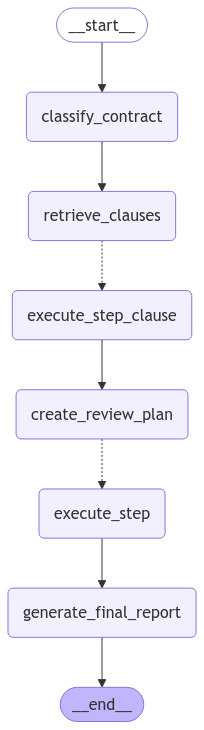

In [65]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from langchain.callbacks.tracers import LangChainTracer
from langchain.callbacks.manager import CallbackManager

# tracer = LangChainTracer(project_name="ContractAI")
# callback_manager = CallbackManager([tracer])

llm = ChatOllama(model = 'llama3.2', temperature=0)

In [67]:
import PyPDF2
def extract_text_from_pdf_file(file_path):
    print('EXTRACTING.....')
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text

# path = '../Data/Employment-Contract-08-21-01.pdf'
path = '../Data/RentalAgreement-MonthtoMonth.pdf'
contract = extract_text_from_pdf_file(path)
primary_objective = "Negotiate better terms and ensure compliance"
specific_focus = ""

EXTRACTING.....


In [68]:
# Example usage
input_state = {
    "contract_text": contract,
    "primary_objective": primary_objective,
    "specific_focus": specific_focus,
}
# Update the config structure
config = {
    "thread_id": "1",  # String instead of nested dict
    "user_id": "user_123"
}

result = graph.invoke(input_state, config)

print(result['final_report'])

CLASSIFTYING CONTRACTS ....
RETRIEVING CONTRACTS ....
VERIFYING IF EACH CLAUSE IF CLEARLY REPRESENTED....VERIFYING IF EACH CLAUSE IF CLEARLY REPRESENTED....
VERIFYING IF EACH CLAUSE IF CLEARLY REPRESENTED....

CREATING A REVIEW PLAN ....
EXECUTING EACH STEP OF REVIEW PLAN ....EXECUTING EACH STEP OF REVIEW PLAN ....
EXECUTING EACH STEP OF REVIEW PLAN ....
EXECUTING EACH STEP OF REVIEW PLAN ....

EXECUTING EACH STEP OF REVIEW PLAN ....
EXECUTING EACH STEP OF REVIEW PLAN ....
GENERATING FINAL REPORT ....
CONTRACT REVIEW REPORT 





CONTRACT OVERVIEW 

Primary Objective: Negotiate better terms and ensure compliance

Specific Focus: 

Contract Type: Rental Agreement

Industry: Residential Real Estate




SECTIONS AND CLAUSES ANALYZED



Total Sections Reviewed: 6

Total Clauses Reviewed: 3




Key Findings and Analysis

-#### Clause Analysis 
 Clear
-#### Clause Analysis 
 The clause is clearly represented in the Rental Agreement (Month-to-Month) document.
-#### Clause Analysis 
 The contr

# USING GEMNI 2.0 FLASH

In [79]:
class ClauseMetaData(BaseModel):
    jurisdiction: str
    version: str
    last_updated: str

class NewClauseRetriever:
    def __init__(self, embedding_model: str, json_file_path: Optional[str] = None):
        self.pc = Pinecone(api_key = os.getenv('PINECONE_API_KEY'))
        
        if embedding_model == 'Llama':
            self.embeddings = OllamaEmbeddings(model = 'llama3.2')
            self.index_name = "contract-clauses"
        elif embedding_model == 'Gemni':
            self.embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")
            self.index_name = "contract-clauses-gemni"
        else:
            raise ValueError("Invalid embedding model. Please choose 'Llama' or 'Gemni'.")

        self.index = self.pc.Index(self.index_name)

        self.vectorstore = Pinecone(index = self.index,
                                    embedding= self.embeddings,
                                    text_key= 'text')
        
        if json_file_path:
            self.load_clauses(json_file_path)
        
    def load_clauses(self, json_file_path: str):
        """Load and index clauses from json file"""

        with open(json_file_path, 'r') as file:
            self.contract_types = json.load(file)
        
        for contract_data in self.contract_types:
            self.index_contract_clauses(contract_data)
        
    def index_contract_clauses(self, contract_data: Dict):
        """Index contract clauses from contract data"""

        contract_type = contract_data['contract_type']

        vectors_to_upsert = []
        for clause in contract_data['clauses']:
            # Creating text to be embedded
            clause_text = f"""
                            Contract Type: {contract_type}
                            Clause Title: {clause['clause_title']}
                            {clause['clause_text']}
                        """
        
            # create metadeta
            metadata = {
                "contract_type": contract_type,
                "clause_title": clause['clause_title'],
                "jurisdiction": clause['metadata']['jurisdiction'],
                "version": clause['metadata']['version'],
                "last_updated": clause['metadata']['last_updated'],
                "text": clause_text
            }

            # get vector embedding
            vector = self.embeddings.embed_query(clause_text)

            # add to upsert batch
            vectors_to_upsert.append({
                "id": f"{contract_type}-{clause['clause_title']}".lower().replace(" ", "-"),
                "values": vector,
                "metadata": metadata
            })

            # batch upsert in chunks of 100
            if len(vectors_to_upsert) >= 100:
                self.index.upsert(vectors=vectors_to_upsert)
                vectors_to_upsert = []
            
        if vectors_to_upsert:
            self.index.upsert(vectors=vectors_to_upsert)

    def get_clauses_by_contract_type(self, contract_type: str, jurisdiction: Optional[str]=None, k: int=5) -> List[Dict]:
        """Get relecant clauses by contract type and jurisdiction"""

        # building a filter dict
        filter_dict = {'contract_type': contract_type}
        if jurisdiction:
            filter_dict['jurisdiction'] = jurisdiction
        
        query_text = f"Find Clauses for {contract_type} cotract"
        query_vector = self.embeddings.embed_query(query_text)

        # search for relevant clauses
        results = self.index.query(
            vector = query_vector,
            top_k = k,
            filter = filter_dict,
            include_values = True,
            include_metadata = True
        )

        # format results
        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']['clause_title'],
                "clause_text": match['metadata']['text'],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })
        
        return formatted_results

    def search_clause(self, query: str, contract_type: Optional[str]=None, jurisdiction: Optional[str]=None, k: int=5) -> List[Dict]:
        """Search for clauses by query and semantic similarity"""

        #build filter dict
        filter_dict = {}
        if contract_type:
            filter_dict['contract_type'] = contract_type
        if jurisdiction:
            filter_dict['jurisdiction'] = jurisdiction

        # create query vector
        query_vector = self.embeddings.embed_query(query)

        # perform search
        results = self.index.query(
            vector = query_vector,
            top_k = k,
            filter = filter_dict if filter_dict else None,
            include_values = True,
            include_metadata = True
        )

        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']['clause_title'],
                "clause_text": match['metadata']['text'],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })
        
        return formatted_results


In [ ]:
clause_retriever = NewClauseRetriever(embedding_model='Gemni', json_file_path = "../Data/clauses.json")

In [82]:
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_community.embeddings import Google

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [ ]:
def classify_contract(state: ContractReviewState):
    """Node to classify the contract type and industry"""

    system_prompt = """Analyze the provided contract and determine:
    1. The type of contract (e.g., Employment, NDA, License Agreement)
    2. The industry it belongs to (if clear from the context)."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Contract text:\n{state['contract_text']}")
    ]

    contract_info = llm.with_structured_output(ContractInfo).invoke(messages)
    return {"contract_info": contract_info}

def retrieve_clauses(state: ContractReviewState):
    """Node to retrieve clauses based on contract type and filter for relevancy"""
    contract_type = state['contract_info'].contract_type

    try:
        # First get ALL General Clauses (no limit)
        general_clauses = clause_retriever.get_clauses_by_contract_type(
            contract_type="General Clauses",
            k=10  # Using a high number to effectively get all clauses
        )

        # Then get specific contract clauses
        specific_clauses = clause_retriever.get_clauses_by_contract_type(
            contract_type=contract_type,
            k=10  # Get more clauses initially since we'll filter them
        )

        # Filter specific clauses for relevancy using LLM
        system_prompt = f"""You are a legal clause relevancy analyzer.
        For each clause, determine if it is relevant for a {contract_type}.
        Respond with either "RELEVANT" or "NOT RELEVANT".
        Base your decision on how essential and appropriate the clause is for this type of contract."""

        filtered_specific_clauses = []
        for clause in specific_clauses:
            messages = [
                SystemMessage(content=system_prompt),
                HumanMessage(content=f"Clause Title: {clause['clause_title']}\n\nClause Text: {clause['clause_text']}")
            ]

            response = llm.invoke(messages).content.strip().upper()
            if response == "RELEVANT":
                filtered_specific_clauses.append(clause)

        # Format clauses for inclusion in the state
        formatted_clauses = []

        # Add ALL General Clauses first
        for clause in general_clauses:
            formatted_clause = f"""### {clause['clause_title']}

            {clause['clause_text']}
            """
            formatted_clauses.append(formatted_clause)

        # Then add filtered specific contract clauses
        for clause in filtered_specific_clauses:
            formatted_clause = f"""### {clause['clause_title']}

            {clause['clause_text']}
            """
            formatted_clauses.append(formatted_clause)

        return {"clauses": formatted_clauses,
                 "current_step": 0}  # Return to clauses instead of sections

    except Exception as e:
        error_message = f"Error retrieving clauses: {str(e)}"
        return {"clauses": [error_message]}

def execute_step_clause(state: ContractReviewState):
    """Node to verify if each clause is clearly represented in the contract"""

    clause = state['clauses'][0]

    system_prompt = f"""You are a Legal Clause Clarity Analyst.
    Review the contract and determine if the following clause is clearly represented:

    {clause}

    Guidelines for your review:
    1. Check if the clause's key elements are present in the contract
    2. Verify if the language is clear and unambiguous
    3. Suggest modifications only if the clause is missing or unclear"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['contract_text'])
    ]

    step_result = llm.with_structured_output(StepAnalysis).invoke(messages)
    clause_summary = f"### Clause Analysis\n{step_result.analysis}"

    return_dict = {
        "clause_analysis": [clause_summary]
    }

    if step_result.modifications:
        return_dict["clause_modifications"] = step_result.modifications

    return return_dict

def create_review_plan(state: ContractReviewState):
    """Node to create a detailed review plan based on different legal roles/perspectives"""

    system_prompt = """You are a legal contract review planner.
    Create a review plan where each step represents a different legal role/perspective for reviewing the contract.

    Context:
    - Contract Type: {contract_type}
    - Industry: {industry}
    - Primary Objective: {objective}
    - Specific Focus: {focus}

    Each step should be a specific role perspective, such as:
    - Employment Law Specialist Review
    - Intellectual Property Counsel Review
    - Compliance Officer Review
    - Financial Terms Specialist Review
    - Risk Management Review
    - Data Privacy Officer Review

    Do not include generic steps or specific clause analysis - that will happen during execution.""".format(
        contract_type=state['contract_info'].contract_type,
        industry=state['contract_info'].industry or "Not specified",
        objective=state['primary_objective'],
        focus=state['specific_focus'] or "Not specified"
    )

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Contract text:\n{state['contract_text']}\n\nGenerate a role-based review plan.")
    ]

    review_plan = llm.with_structured_output(ReviewPlan).invoke(messages)
    return {
        "review_plan": review_plan,
        "current_step": 0
    }

def execute_step(state: ContractReviewState):
    """Node to execute each step of the review plan with specific analysis"""

    role = state['review_plan'][0]
    print(role)

    system_prompt = f"""You are a {role}.
    Review the contract from your professional perspective.

    Guidelines for your review:
    1. Identify specific sections that fall under your expertise
    2. Analyze those sections in detail
    3. Suggest concrete modifications where necessary

    Your response should include:
    1. analysis: A detailed explanation of your review findings
    2. modifications: A list of suggested changes, each containing:
       - original_text: The exact text to be modified
       - suggested_text: Your proposed replacement
       - reason: Clear reasoning for the change based on your role

    You may suggest multiple modifications or none if appropriate."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['contract_text'])
    ]

    step_result = llm.with_structured_output(StepAnalysis).invoke(messages)
    section_summary = f"### {role}\n{step_result.analysis}"

    return {
        "modifications": step_result.modifications,
        "sections": [section_summary]
    }

def generate_final_report(state: ContractReviewState):
    """Node to generate the final report and summary."""
    # Extract relevant data from the state
    contract_text = state["contract_text"]
    primary_objective = state["primary_objective"]
    specific_focus = state.get("specific_focus", "Not specified")
    contract_type = state["contract_info"].contract_type
    industry = state["contract_info"].industry or "Not specified"
    review_plan = state["review_plan"]
    clause_modifications = state["clause_modifications"]
    planner_modifications = state["modifications"]
    sections = state["sections"]
    clause_analysis = state["clause_analysis"]
    clauses = state["clauses"]

    # Combine all modifications for LLM processing
    all_modifications = clause_modifications + planner_modifications

    # Prepare the system prompt
    system_prompt = (
        "You're a modifications reviewer, you get a list of modifications.\n"
        "class Modification(BaseModel):\n"
        "  original_text: str = Field(description='Original contract text')\n"
        "  suggested_text: str = Field(description='Suggested modification')\n"
        "  reason: str = Field(description='Reason for modification')\n\n"
        "Please summarize them, mostly focusing on the reason and explain it from a legal expert's point of view.\n\n"
        "The modifications:\n"
        f"{all_modifications}\n"
    )

    # Generate the messages
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="Please summarize the modifications")
    ]

    # Invoke the LLM
    try:
        review_plan = llm.invoke(messages)
        modification_summary = review_plan.content
    except Exception as e:
        modification_summary = f"Error generating summary: {str(e)}"

    # Generate the report
    report = "\n".join([
        "===============================================",
        "                  Contract Review Report       ",
        "===============================================",
        "",
        "Contract Overview",
        "-----------------",
        f"Primary Objective: {primary_objective}",
        f"Specific Focus: {specific_focus}",
        "",
        f"Contract Type: {contract_type}",
        f"Industry: {industry}",
        "",
        "Sections and Clauses Analyzed:",
        "------------------------------",
        f"Total Sections Reviewed: {len(sections)}",
        f"Total Clauses Analyzed: {len(clauses)}",
        "",
        "Key Findings and Analysis:",
        "--------------------------",
        "\n".join(f"- {analysis}" for analysis in clause_analysis),
        "",
        "Highlights of Suggested Modifications:",
        "--------------------------------------",
        modification_summary,
        "",
        "Compliance and Risk Assessment:",
        "-------------------------------",
        "- The contract has been reviewed for compliance with relevant laws and regulations.",
        "- Potential risks and mitigation strategies have been identified.",
        "- Tailored suggestions have been provided to enhance the contract’s effectiveness.",
        "",
        "Final Notes:",
        "------------",
        "Please ensure all suggested modifications are incorporated and reviewed by a legal expert before finalizing the contract.",
        "",
        "===============================================",
        "                  End of Report               ",
        "===============================================",
    ])

    return {"final_report": report}



In [88]:
from langgraph.constants import Send

def continue_to_clauses_check_execute(state: ContractReviewState):
    return [Send("execute_step_clause", {"contract_text": state["contract_text"], "clauses": c}) for c in state["clauses"]]


def continue_to_plan_check_execute(state: ContractReviewState):
    return [Send("execute_step", {"contract_text": state["contract_text"], "review_plan": step}) for step in state["review_plan"].steps]



In [89]:
builder = StateGraph(ContractReviewState)

#nodes in the graph
builder.add_node('classify_contract', classify_contract)
builder.add_node('retrieve_clauses', retrieve_clauses)
builder.add_node('execute_step_clause', execute_step_clause)
builder.add_node('create_review_plan', create_review_plan)
builder.add_node('execute_step', execute_step)
builder.add_node('generate_final_report', generate_final_report)

#edged in the graph connecting different nodes
builder.add_edge(START, 'classify_contract')
builder.add_edge('classify_contract', 'retrieve_clauses')

builder.add_conditional_edges('retrieve_clauses', continue_to_clauses_check_execute, ['execute_step_clause'])
builder.add_edge('execute_step_clause', 'create_review_plan')

builder.add_conditional_edges('create_review_plan', continue_to_plan_check_execute, ['execute_step'])
builder.add_edge('execute_step', 'generate_final_report')

builder.add_edge('generate_final_report', END)

checkpointer = MemorySaver()

in_memory_store = InMemoryStore()

graph = builder.compile(
    checkpointer = checkpointer,
    store = in_memory_store
)


In [90]:
# Example usage
input_state = {
    "contract_text": contract,
    "primary_objective": primary_objective,
    "specific_focus": specific_focus,
}
# Update the config structure
config = {
    "thread_id": "1",  # String instead of nested dict
    "user_id": "user_123"
}

result = graph.invoke(input_state, config)

print(result['final_report'])

AttributeError: 'str' object has no attribute 'steps'